# Fitting empirical copulas to Monte Carlo results
The data we are working on here came from some Bayesian Monte Carlo runs on the Hector climate model.  The data represent parameters from the joint probability distribution of the parameters.  Can we learn anything about the distribution by fitting copula models to it?

In [1]:
suppressMessages(library(here))
library(ggplot2)
suppressMessages(library(GGally, warn.conflicts=FALSE))
library(copula)

source(here('R', 'example-data.R'), echo=FALSE)
source(here('R', 'plots.R'), echo=FALSE)
hsamps <- readRDS(here('data-raw', 'hcsamps.rds'))
set.seed(867-5309)

Here is the raw data:

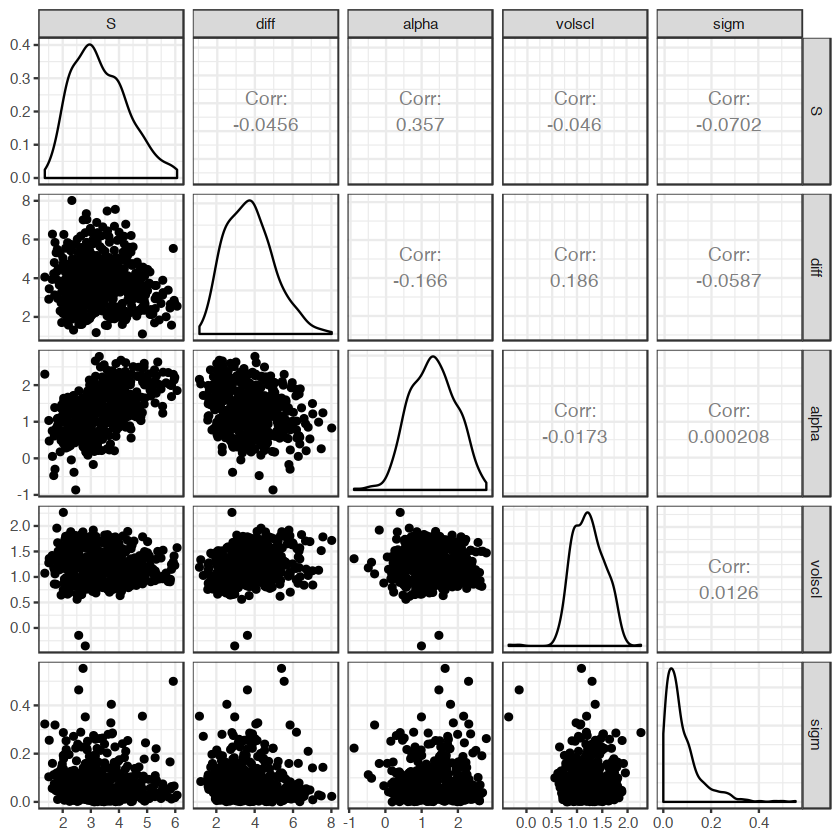

In [2]:
pairplot_mat(hsamps[sample.int(nrow(hsamps), 500), ])

Here is what it looks like transformed to pseudo-observations:

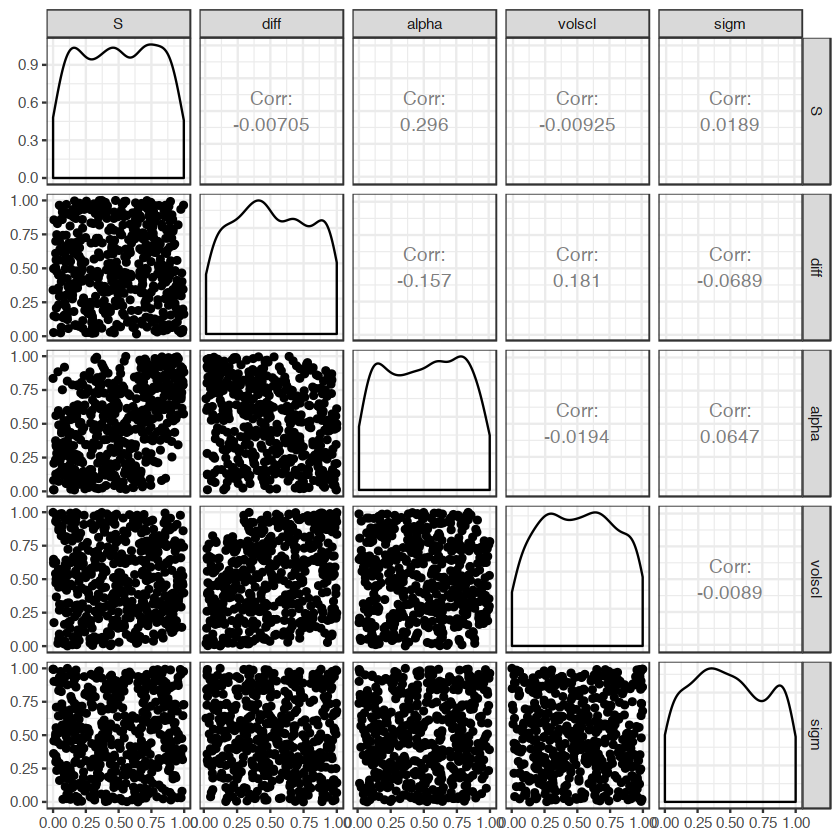

In [3]:
hpobs <- pobs(hsamps)
pairplot_mat(hpobs[sample.int(nrow(hpobs), 500), ])

Except for $S$ and $\alpha$, there doesn't seem to be a lot of obvious dependence here.  Maybe this won't be so interesting after all.  The $\tau$ values are printed in the graph above.  Let's see about the $\lambda$ values.

In [4]:
fitLambda(hpobs, lower.tail=TRUE)
fitLambda(hpobs, lower.tail=FALSE)

1.00000000,0.01308385,0.21128872,0.05057206,0
0.01308385,1.00000000,0.00000000,0.05349241,0
0.21128872,0.00000000,1.00000000,0.05719347,0
0.05057206,0.05349241,0.05719347,1.00000000,0
0.00000000,0.00000000,0.00000000,0.00000000,1


1.000000000,0.00000000,0.003823669,0.009673783,0.08222775
0.000000000,1.00000000,0.000000000,0.071450578,0.00753401
0.003823669,0.00000000,1.000000000,0.015814258,0.10526698
0.009673783,0.07145058,0.015814258,1.000000000,0.06385812
0.082227746,0.00753401,0.105266979,0.063858121,1.00000000


None of the pairs of variables have any significant tail dependence.  Even $S$ and $\alpha$ have only a slight lower tail dependence.  This is looking more and more like a washout.  We can fit the empirical copula, but it doesn't buy us much.

In [5]:
dim <- 5
nsamp <- nrow(hpobs)
evalpts <- matrix(runif(nsamp*dim), ncol=dim)
ec <- C.n(evalpts, hpobs)

Sadly, there isn't much we can do with this, other than sample from it and evaluate its df and density, and the empirical copula isn't really much more compact than the dataset it is derived from.  Since it looks like there might be some lower tail dependence between $S$ and $\alpha$, we'll close by fitting a Clayton copula to just that pair of variables.

In [6]:
salpha <- hpobs[, c(1,3)]
fit.clay <- fitCopula(claytonCopula(), salpha, method='itau')
summary(fit.clay)

Call: fitCopula(copula, data = data, method = "itau")
Fit based on "inversion of Kendall's tau" and 10000 2-dimensional observations.
Clayton copula, dim. d = 2 
      Estimate Std. Error
alpha   0.9826      0.023

The estimate of the Clayton parameter is approximately 1, with a standard error that pretty strongly excludes 0 (which is equivalent to independence).  We could follow this up with some diagnostics.  What we really want to know is, is the lower tail dependence that we see in the raw data real?   

In [7]:
## This function runs for a long time and never seems to complete...
#gofCopula(claytonCopula(0.98, dim=2), salpha, simulation='mult')